In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import netCDF4 as nc4

import xarray as xr

In [2]:
pmm = "netcdf_files/eORCA1.4.2_ModifStraits_domain_cfg.nc"

mm = nc4.Dataset(pmm)

glamt = mm.variables['glamt'][0] ; e1t = mm.variables['e1t'][0]
gphit = mm.variables['gphit'][0] ; e2t = mm.variables['e2t'][0] 
# U-V facets
e3t_1d = mm.variables['e3t_1d'][0] ; e3t_0 = mm.variables['e3t_0'][0] ; e3u_0 = mm.variables['e3u_0'][0]; e3v_0 = mm.variables['e3v_0'][0]
# partial cells
e3w_0 = mm.variables['e3w_0'][0] ; e3uw_0 = mm.variables['e3uw_0'][0] ; e3vw_0 = mm.variables['e3vw_0'][0]
e3w_1d = mm.variables['e3w_1d'][0]
#
totl = mm.variables['top_level'][0]  # 
botl = mm.variables['bottom_level'][0]  # goes from 0 to 74 (75 levels)
bath = mm.variables['bathy_meter'][0]   # 
nK,nJ,nI = np.shape(e3w_0)
mm.close()

---
# Smooth out bathymetry

- For one column $(i,j)$ interpolate $b_{i,j}$ with the surrounding cells
  - if (i,j) is in the protected list, just skip it (as the partial cells alreay done)
  - coastlines cells unchanged below 10m
- Select vertically the vertically cells, find the intersections, cut it
- update bottom_level, e3t_0, gdepw and gdept at the bottom cells

Then save to .nc

---
### Read the protected cells

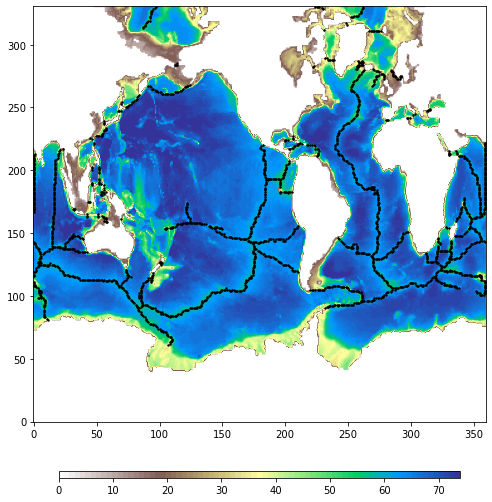

In [3]:
# https://mpl-point-clicker.readthedocs.io/en/latest/
palette = plt.get_cmap("terrain_r",75)
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,9))
cf = plt.imshow(botl, cmap=palette)
fig.colorbar(cf,orientation="horizontal",shrink=0.8, location='bottom',aspect = 60, fraction=0.05,pad = 0.1)
ax.set_aspect(aspect='equal')

try : 
    with open('protected_cells_230113.npy', 'rb') as f:
        protected_nodes = np.load(f)
except :
    print("list not found")
plt.scatter(protected_nodes[:,0],protected_nodes[:,1],color="k", s=2)
# add zooming and middle click to pan
ax.invert_yaxis()
ax.patch.set_color('0.7')


plt.show()

In [4]:
""" 1) handle exceptions
"""
mindex = np.zeros((nJ,nI))
with open('protected_cells_230113.npy', 'rb') as f:
    protected_nodes = np.load(f)

for node in protected_nodes:
    ii,jj = node
    mindex[jj,ii] = -1

In [5]:
""" 2.1) build the meaned bathymetry bathf
"""
# bathf # need a wet mean, coastlines or isolated island generate spurious slopes
bathf = 0.*np.copy(bath)
for i in range(1,nI-1):
    for j in range(1,nJ-1):
        #
        top_sum = totl[j+1,i] + totl[j+1,i+1] \
                + totl[j  ,i] + totl[j  ,i+1]
        if top_sum != 0 :
            # else coastland
            bathf[j,i] = ( bath[j+1,i] + bath[j+1,i+1]   \
                         + bath[j  ,i] + bath[j  ,i+1] ) / top_sum
        #

j = nJ-1 # Arctique # j = 0 Antartique
#slice at cell 180(NEMO)->179(netcdf,python) on a U face (Canada)
for i in range(nI-1):
    c4 = (j,180-(i-179)) ; c3 = (j,180-(i+1-179)) #   | 4 | 3 |   
    c1 = (j,i          ) ; c2 = (j,i+1          ) #   --- + ---   
    #                                             #   | 1 | 2 | 
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

i = nI-1 # east indian ocean
for j in range(nJ-1):
    c4 = (j+1,i) ; c3 = (j+1,0)  
    c1 = (j  ,i) ; c2 = (j  ,0)  
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

i = 0 # west indian ocean
for j in range(nJ-1):
    c4 = (j+1,nI-1) ; c3 = (j+1,i)  
    c1 = (j  ,nI-1) ; c2 = (j  ,i) 
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

#! corners masked inland

""" 2.2) smoothed_bath = meaned(bathf)
"""

smoothed_bath = np.copy(bath) # in T
for i in range(1,nI):
    for j in range(1,nJ):
        if mindex[j,i]==-1 or not totl[j,i] : continue
        smoothed_bath[j,i] = 0.25 * ( bathf[j  ,i-1] + bathf[j  ,i] \
                                    + bathf[j-1,i-1] + bathf[j-1,i] )
        
i = 0 # west indian ocean
for j in range(nJ-1):
    if mindex[j,i]==-1 or not totl[j,i] : continue
    
    c4 = (j  ,nI-1) ; c3 = (j  ,i)  
    c1 = (j-1,nI-1) ; c2 = (j-1,i) 
    smoothed_bath[j,i] = 0.25 * ( bathf[c4] + bathf[c3] \
                                + bathf[c1] + bathf[c2] )

In [6]:
""" 3) partial cells
    z : PYTHON+1=NEMO
"""
depw_1d = np.zeros((nK))
for k in range(1,nK):
    depw_1d[k] = depw_1d[k-1] + e3t_1d[k-1]

bottom_levelp = np.copy(botl) # indice dernier T-niveau mouillé (en NEMO 1->jpk)
bottom_levelp[:,:] = nK -1    # jpkm1 (NEMO)
for k in range(nK-1,-1,-1):
    ze3min = 0.1 * e3t_1d[k]
    b,a=np.where( smoothed_bath <  depw_1d[k] + ze3min )
    #b,a=np.where( bath <  depw_1d[k] + ze3min )
    bottom_levelp[b,a] = k+1 -1 # T +1(python) -> bottom_levelp pour NEMO (1->jpk - 0 pour continent)
#exception np.sum(botl!=bottom_levelp)->1
#bottom_levelp[87,282]=72 # et non pas 71 avec bath

bathy_meterp = np.copy(smoothed_bath)

""" Partial Step à la NEMO
"""
e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI))
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]
        e3tp[:,j,i] = e3t_1d[:]
        k0 = bottom_levelp[j,i] -1 #-1 (indicage python)
        if k0>0:
            e3tp[k0,j,i] = smoothed_bath[j,i] - depw_1d[k0] # garde les plus grosses cellules
            e3wp[k0,j,i] = 0.5 * (e3tp[k0-1,j,i] + e3tp[k0,j,i])
            #
            e3tp[k0+1,j,i] = e3tp[k0,j,i] 
            e3wp[k0+1,j,i] = e3tp[k0,j,i] 

In [7]:
""" 4) 2-points mean
"""
e3fp = np.copy(e3tp)
for j in range(1,nJ-1):
    for i in range(1,nI-1):
        e3fp[:,j,i] = ( e3tp[:,j+1,i] + e3tp[:,j+1,i+1]   \
                      + e3tp[:,j  ,i] + e3tp[:,j  ,i+1] ) / 4.

j = nJ-1 # Arctique # jj = 0 Antartique
#slice at cell 180(NEMO)->179(netcdf,python) on a U face (Canada)
for i in range(nI-1):
    c4 = (j,180-(i-179)) ; c3 = (j,180-(i+1-179)) #   | 4 | 3 |   
    c1 = (j,i          ) ; c2 = (j,i+1          ) #   --- + ---   
    #                                             #   | 1 | 2 | 
    e3fp[:,j,i] = ( e3tp[:,c4[0],c4[1]] + e3tp[:,c3[0],c3[1]]   \
                  + e3tp[:,c1[0],c4[1]] + e3tp[:,c2[0],c2[1]] ) / 4.

i = nI-1 # east indian ocean
for j in range(nJ-1):
    c4 = (j+1,i) ; c3 = (j+1,0)  
    c1 = (j  ,i) ; c2 = (j  ,0)  
    e3fp[:,j,i] = ( e3tp[:,c4[0],c4[1]] + e3tp[:,c3[0],c3[1]]   \
                  + e3tp[:,c1[0],c4[1]] + e3tp[:,c2[0],c2[1]] ) / 4.

i = 0 # west indian ocean
for j in range(nJ-1):
    c4 = (j+1,nI-1) ; c3 = (j+1,i)  
    c1 = (j  ,nI-1) ; c2 = (j  ,i) 
    e3fp[:,j,i] = ( e3tp[:,c4[0],c4[1]] + e3tp[:,c3[0],c3[1]]   \
                  + e3tp[:,c1[0],c4[1]] + e3tp[:,c2[0],c2[1]] ) / 4.

---
### e3u=moy(e3t)

In [8]:
""" 4.1) e3u,v moyenne
"""
e3up = np.copy(e3u_0) ; 
for j in range(1,nJ):
    for i in range(0,nI-1):
        if totl[j,i+1]+totl[j,i] !=2 : continue
        e3up[:,j,i] = 0.5 * ( e3tp[:,j  ,i+1] + e3tp[:,j,i] ) # moyenne i
        
i = nI-1 # east indian ocean
for j in range(nJ):
    if totl[j,0]+totl[j,i] !=2 : continue
    e3up[:,j,i] = 0.5 * ( e3tp[:,j,0] + e3tp[:,j,i] )
    
e3vp = np.copy(e3v_0)
for j in range(0,nJ-1):
    for i in range(0,nI):
        if totl[j+1,i]+totl[j,i] !=2 : continue
        e3vp[:,j,i] = 0.5 * ( e3tp[:,j+1,i  ] + e3tp[:,j,i] ) # moyenne j

j = nJ-1 # Arctique # jj = 0 Antartique
#slice at cell 180(NEMO)->179(netcdf,python) on a U face (Canada)
for i in range(nI):
    c4 = (j,180-(i-179))  #   | 4  |   
    c1 = (j,i          )  #   --+--|   
    #                     #   | 1  | 
    if totl[c4[0],c4[1]]+totl[c1[0],c1[1]] !=2 : continue
    e3vp[:,j,i] = 0.5 * ( e3tp[:,c4[0],c4[1]] \
                        + e3tp[:,c1[0],c1[1]] )
flagU="e3u moyenne"
psave = "penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_refsmo_pcmoy.nc"

---
### e3u = min(e3t)

In [22]:
""" 4.2) e3u,v minimum
"""
e3up = np.copy(e3u_0) ; 
for j in range(1,nJ):
    for i in range(0,nI-1):
        if totl[j,i+1]+totl[j,i] !=2 : continue
        e3up[:,j,i] = np.min([e3tp[:,j,i+1],e3tp[:,j,i]],axis=0) # min i
        
i = nI-1 # east indian ocean
for j in range(nJ):
    if totl[j,0]+totl[j,i] !=2 : continue
    e3up[:,j,i] = np.min([e3tp[:,j,0],e3tp[:,j,i]],axis=0) 
    
e3vp = np.copy(e3v_0)
for j in range(0,nJ-1):
    for i in range(0,nI):
        if totl[j+1,i]+totl[j,i] !=2 : continue
        e3vp[:,j,i] = np.min([e3tp[:,j+1,i],e3tp[:,j,i]],axis=0) # min j

j = nJ-1 # Arctique # jj = 0 Antartique
#slice at cell 180(NEMO)->179(netcdf,python) on a U face (Canada)
for i in range(nI):
    c4 = (j,180-(i-179))  #   | 4  |   
    c1 = (j,i          )  #   --+--|   
    #                     #   | 1  | 
    if totl[c4[0],c4[1]]+totl[c1[0],c1[1]] !=2 : continue
    e3vp[:,j,i] = np.min([e3tp[:,c4[0],c4[1]],
                          e3tp[:,c1[0],c1[1]]],axis=0)
flagU="e3u minimum"
psave = "penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_refsmo_pcmin.nc"

In [23]:
""" 5) write
"""
#psave = "penalised_domain/test.nc"
#psave = "penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_ref_smoothed.nc"

ds=xr.open_dataset(pmm)

#e3w_0
ds.e3w_0 [0]=e3wp
ds.e3uw_0[0]=e3wp
ds.e3vw_0[0]=e3wp

#bathy_meter, bottom_level
ds.bathy_meter [0] = bathy_meterp
ds.bottom_level[0] = bottom_levelp

#e3t_0
ds.e3t_0[0]=e3tp
ds.e3u_0[0]=e3up
ds.e3v_0[0]=e3vp
ds.e3f_0[0]=e3fp

ds.to_netcdf(psave) # rewrite to netcd
ds.close()
print("written : %s" % (psave))
print(flagU)

written : penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_refsmo_pcmin.nc
e3u minimum


--- 
# Début pénalisation

In [ ]:
""" Partial Step à la Pénalisé
"""
e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI))
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]
        e3tp[:,j,i] = e3t_1d[:]
        k0 = bottom_levelp[j,i] -1 #-1 (indicage python)
        if k0>0:
            e3tp[k0,j,i] = smoothed_bath[j,i] - depw_1d[k0] 

---
### Test : fond plat

In [11]:
""" FOND PLAT
"""
bottom_levelp = np.copy(botl) # indice dernier T-niveau mouillé (en NEMO 1->jpk)
bottom_levelp[bottom_levelp>0] = nK -1    # jpkm1

In [ ]:
bathy_meterp = np.copy(smoothed_bath)

psave = "penalised_domain/test.nc"

ds=xr.open_dataset(pmm)

#bathy_meter, bottom_level
ds.bathy_meter [0] = bathy_meterp
ds.bottom_level[0] = bottom_levelp

#ds.to_netcdf(psave) # rewrite to netcd
ds.close()
print("written : %s" % (psave))

In [ ]:
depw[1]

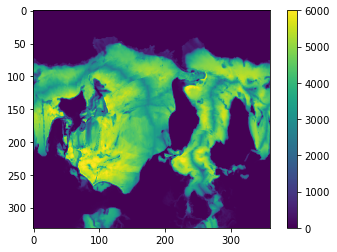

In [13]:
plt.imshow(bath)
plt.colorbar()

---
# Prints intéressants


In [ ]:
plt.imshow((bottom_levelp==0) == (botl==0))
plt.colorbar()

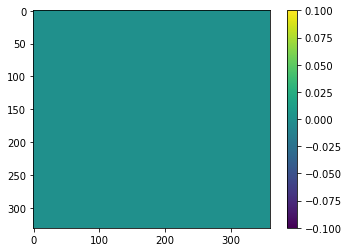

In [147]:
depw = np.zeros((nJ,nI)) ; dept = np.zeros((nJ,nI))
# z : PYTHON+1=NEMO
for j in range(nJ):
    for i in range(nI):
        k0 = botl[j,i]
        # botl[j,i] est la dernière cellule mouillé NEMO
        # botl[j,i]-1 dans python
        # botl[j,i]-1+1 pour le slicing
        depw[j,i] = np.sum(e3t_0[:k0,j,i])
        dept[j,i] = np.sum(e3w_0[:k0,j,i]) - 0.5*e3w_0[0,j,i] 
        #dept[j,i] = np.sum(e3w_1d[:k0]) - 0.5*e3w_1d[0]     # comme pour la pénalisation overflow
     
b,a = np.where(depw<dept)
plt.imshow(depw<dept) 
plt.colorbar()

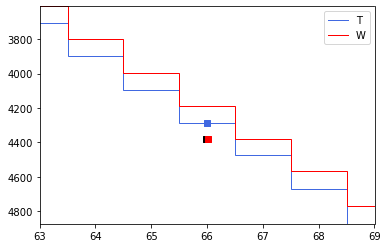

In [149]:
#j = 180 ; i = 30 
j = 51 ; i = 131 
#_=30 ; j = b[_] ; i = a[_]

topo = bath
k0 = botl[j,i]-1 # for python 
e3t = e3t_0 ; e3w = e3w_0

#topo = smoothed_bath
#k0 = bottom_levelp[j,i]-1 # for python 
#e3t = e3tp ; e3w = e3wp

depw_1d = np.zeros((nK))
for k in range(1,nK):
    depw_1d[k] = depw_1d[k-1] + e3t[k-1,j,i]

dept_1d = np.zeros((nK))
dept_1d[0] = 0.5*e3wp[0,j,i]
for k in range(1,nK):
    dept_1d[k] = dept_1d[k-1] + e3w[k,j,i]
    
%matplotlib inline
npass = 3
fig, ax = plt.subplots()
ax.invert_yaxis()
zindex = np.arange(0,nK+1)-0.5
plt.stairs(dept_1d, edges = zindex,label="T",color="royalblue")
plt.stairs(depw_1d, edges = zindex,label="W",color="red")
plt.scatter(zindex[k0]+0.50,dept_1d[k0  ],marker = 's',c='royalblue',s=40)
plt.scatter(zindex[k0]+0.48,topo    [j,i] ,marker = 's',c='black'    ,s=40)
plt.scatter(zindex[k0]+0.52,depw_1d[k0+1],marker = 's',c='red'      ,s=40)

#zindex = np.arange(0,nK)
#plt.plot(zindex,dept_1d,'_',label="T",markersize=10, markeredgewidth=2)
#plt.plot(zindex,depw_1d,'_',label="W",markersize=10, markeredgewidth=2)
#plt.scatter(zindex[k0],dept_1d[k0],c='black',s=10)

ax.legend()
ax.set_xlim(k0-npass,k0+npass)
ax.set_ylim(dept_1d[k0+npass],depw_1d[k0-npass])
plt.show()